In [1]:
import numpy as np

# Import PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

import copy
import time
from itertools import repeat

from IPython.display import clear_output

In [3]:
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'
device

'cpu'

In [4]:
import tensorly as tl
import tensorly.decomposition
import tensorly.random

In [52]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import tensorly; print("TensorLy", tensorly.__version__)
import torch; print("PyTorch", torch.__version__)

Darwin-19.6.0-x86_64-i386-64bit
Python 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
NumPy 1.19.4
SciPy 1.5.4
TensorLy 0.5.0
PyTorch 1.7.0


In [6]:
tl.set_backend('pytorch')

In [7]:
random_state = 1234
rng = tensorly.random.check_random_state(random_state)

In [8]:
# ### import data

# dir_factors_np = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
# fileName_factors_np = f'factors_np.npy'
# path_factors_np = f'{dir_factors_np}/{fileName_factors_np}'
# factors_np = np.load(path_factors_np , allow_pickle=True)
# print(f'inputTensor shape: {factors_np.shape}')

In [9]:
tmp_shape = (820, 49, 29323, 2)  # used if you're loading in the memmapped version of the dataset

In [10]:
### import data

# dir_inputTensor = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
# fileName_inputTensor = f'Sxx_allPixels.npy'
# path_inputTensor = f'{dir_inputTensor}/{fileName_inputTensor}'
# inputTensor = np.memmap('/Users/wingillis/gdrive/datta/for_Win/Sxx_allPixels.npy', shape=tmp_shape)
inputTensor = np.load('/Users/wingillis/gdrive/datta/for_Win/Sxx_allPixels.npy')
print(f'inputTensor shape: {inputTensor.shape}')

inputTensor shape: (820, 49, 29323, 2)


In [11]:
inputTensor = inputTensor[:, :, :5000, :]  # for quickly iterating through tests

In [12]:
### Make dataset objects

class make_batchSlices_dataObj(Dataset):
    def __init__(self, input_tensor):
        """
        Args:
            input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
        """
        self.tensor_full = input_tensor
    def __len__(self):
        return self.tensor_full.shape[2]
    def __getitem__(self, idx):
        tensor_slice = torch.tensor(self.tensor_full[:,:,idx,:], dtype=torch.float32, device=device, requires_grad=True)
        return tensor_slice, idx
    
# class make_batchFilaments_dataObj(Dataset):
#     def __init__(self, input_tensor):
#         """
#         Args:
#             input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
#         """
#         self.tensor_full = input_tensor
#         self.shape_tensor = self.tensor_full.shape
#     def __len__(self):
#         return self.shape_tensor[0] * self.shape_tensor[1] * self.shape_tensor[3]
#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()     
#         idx_subscripts = np.unravel_index([idx], (self.shape_tensor[0] , self.shape_tensor[1] , self.shape_tensor[3]) , order='F')
#         # order='F' necessary to make it (dim 0 , dim1 , dim2, ...)
#         idx_subscripts = np.array(idx_subscripts)
        
#         tensor_filament = torch.tensor(self.tensor_full[idx_subscripts[0], idx_subscripts[1], :, idx_subscripts[2]],
#                                        dtype=torch.float32, device=device, requires_grad=True)
#         return tensor_filament, idx, idx_subscripts

In [69]:
##Define Function and class to be used
eps = 1.3e-7  # Slightly higher than min value of fp32
prox_plus = nn.Threshold(0, eps) ## to make all output postive 

class NTF(nn.Module): ## Model
    def __init__(self, shapes, rank):
        super(NTF, self).__init__()
        for i, (s, r) in enumerate(zip(shapes, repeat(rank)), start=1):
          setattr(self, 'factors{}'.format(i), nn.Parameter(torch.tensor(rng.random_sample((s, r)), dtype=torch.float32)))
        self.weights = nn.Parameter(torch.tensor(np.ones(rank), dtype=torch.float32), requires_grad=True)
        
    def forward(self, idx):
        # if 'batchSlices' then idx should be scalar
        # if 'batchFilaments' then idx should be 3-tuple or 3-value array
#         tmp = [F.relu(self.factors3[idx]),
#                F.relu(self.factors1),
#                F.relu(self.factors2),
#                F.relu(self.factors4)]
        tmp = [self.factors3[idx],
               self.factors1,
               self.factors2,
               self.factors4]
        
#         reconstruction = prox_plus(tl.cp_tensor.cp_to_tensor((weights, tmp)))
        reconstruction = F.relu(tl.cp_tensor.cp_to_tensor((self.weights, tmp)))
        return reconstruction


class NonNegativeClipper(object):
    def __init__(self, frequency=50, eps=1e-8):
        self.pos_constraint = nn.Threshold(0, eps)
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        
        for param in module.parameters():
            param.data = self.pos_constraint(param.data)
#             param.data.sub_(param*(param<=0) - eps*1)
            
print('Start training on Task 1...')

Start training on Task 1...


In [70]:
batch_size = 512

batchSlices_dataObj = make_batchSlices_dataObj(inputTensor)
dataloader_batchSlices = DataLoader(batchSlices_dataObj, batch_size=batch_size, drop_last=False,
                        shuffle=True, num_workers=0)
# batchFilaments_dataObj = make_batchFilaments_dataObj(inputTensor)
# dataloader_batchFilaments = DataLoader(batchFilaments_dataObj, batch_size=1, drop_last=True,
#                         shuffle=True, num_workers=0)

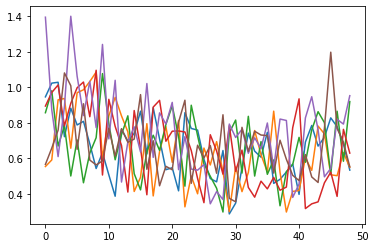

In [ ]:
# goal_tensor = tensor
rank = 6
ntf_obj = NTF(inputTensor.shape, rank).to(device)
loss_rolling = [] #collect loss

n_epoch = 10000
# lr = 0.0075
lr = 0.01
# lr = 0.2
penalty_L1 = 0.1
penalty_L2 = 0.1
weight_decay = 0.2
display_every = 2  # iterations
# loss_fn = nn.MSELoss(reduction='sum')
repeats = 4

# optimizer = optim.SGD(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr)
optimizer = torch.optim.Adam(ntf_obj.parameters(), lr=lr) #,weight_decay=weight_decay)

clipper = NonNegativeClipper(frequency=1)

for epoch in range(n_epoch):
#     torch.cuda.empty_cache()
    for n_iter_batchSlices, (tensor_batchSlices, idx_batchSlices) in enumerate(dataloader_batchSlices):
        msk = np.isin(np.arange(inputTensor.shape[2]), idx_batchSlices)
        start = time.time()
        for rep in range(repeats):
          ntf_obj.factors1.requires_grad = True
          ntf_obj.factors2.requires_grad = True
          ntf_obj.factors3.requires_grad = False
          ntf_obj.factors4.requires_grad = True
          optimizer.zero_grad() # need to clear the old gradients
          Y_ = ntf_obj(idx_batchSlices)
          loss = tl.norm((Y_ - tensor_batchSlices), 2)
          loss.backward(retain_graph=True)
          optimizer.step()

          ntf_obj.factors1.requires_grad = False
          ntf_obj.factors2.requires_grad = False
          ntf_obj.factors3.requires_grad = True
          ntf_obj.factors4.requires_grad = False

          _weights = ntf_obj.factors3.detach()
          optimizer.zero_grad() # need to clear the old gradients
          Y_ = ntf_obj(idx_batchSlices)
          loss = tl.norm((Y_ - tensor_batchSlices), 2)
          loss.backward(retain_graph=True)
          optimizer.step()
          with torch.no_grad():
            ntf_obj.factors3[msk] = _weights[msk]
            
          if rep % clipper.frequency == 0:
              ntf_obj.apply(clipper)

        if n_iter_batchSlices % display_every == 0:
            clear_output()
            loss_rolling.append(loss.item() / len(idx_batchSlices))
            print("Epoch {} -- Time per iter: {:0.3f}s -- loss: {:0.3f}".format(epoch, time.time() - start, loss.item() / len(idx_batchSlices)), end='\r')
            plt.plot(ntf_obj.factors2.detach())
            plt.show()

print('Learning curve for Task 1')

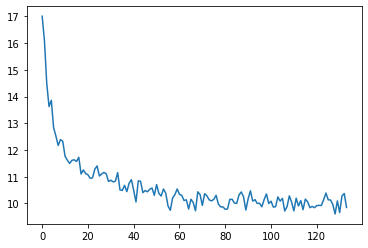

In [63]:
plt.plot(loss_rolling)

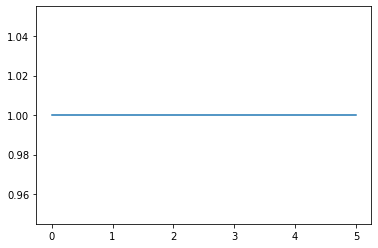

In [64]:
plt.plot(ntf_obj.weights.detach())

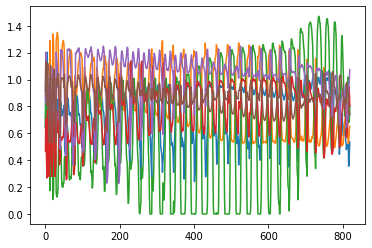

In [65]:
plt.plot(ntf_obj.factors1.detach())

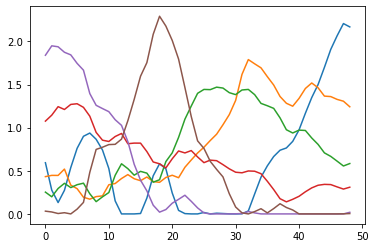

In [66]:
plt.plot(ntf_obj.factors2.detach())

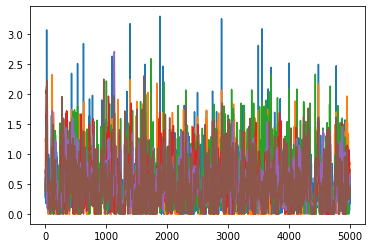

In [67]:
plt.plot(ntf_obj.factors3.detach())

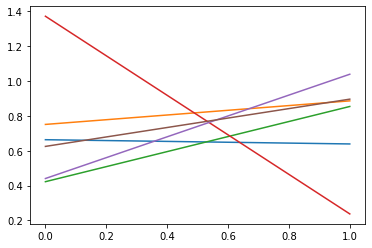

In [68]:
plt.plot(ntf_obj.factors4.detach())